# CESM Terrain Elevation Visualization - North America

This notebook visualizes CESM (Community Earth System Model) terrain elevation data for North America at three different resolutions:
- **Coarse (~1.9°×2.5°)**: `fv_1.9x2.5_nc3000_Nsw084_Nrs016_Co120_Fi001_ZR_GRNL_031819.nc`
- **Medium (~0.9°×1.25°)**: `fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_160505.nc`
- **Fine (~0.47°×0.63°)**: `fv_0.47x0.63_nc3000_Co030_Fi001_PF_nullRR_Nsw021_20171023.nc`

## Outputs

- `CESM_terrain_NA_multiresolution.png`: Comparison plot showing all three resolutions side by side
- `CESM_terrain_NA_f19.png`, `CESM_terrain_NA_f09.png`, `CESM_terrain_NA_f05.png`: Individual plots for each resolution

## Purpose

This visualization demonstrates how CESM grid resolution affects terrain representation across North America, showing the trade-off between computational cost and topographic detail.


## Setup and Installation

Install required packages if not already installed.

In [13]:
# Install required packages
%pip install xarray netCDF4 matplotlib cartopy

Note: you may need to restart the kernel to use updated packages.


In [14]:
# Import required libraries
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# Define helper function to calculate grid edges for pcolormesh
def calculate_grid_edges(lon_values_raw, lat_values, lon_spacing, lat_spacing, plot_extent):
    """
    Calculate grid cell edges for pcolormesh, ensuring they extend to plot extent.
    
    Parameters:
    -----------
    lon_values_raw : array
        Longitude values in 0-360 format
    lat_values : array
        Latitude values
    lon_spacing : float
        Longitude spacing
    lat_spacing : float
        Latitude spacing
    plot_extent : tuple
        (lon_min, lon_max, lat_min, lat_max) in -180/180 format
        
    Returns:
    --------
    lon_edges : array
        Longitude edges in -180/180 format
    lat_edges : array
        Latitude edges
    """
    # Convert plot extent lon to 0-360 if needed
    lon_min_extent = plot_extent[0] + 360 if plot_extent[0] < 0 else plot_extent[0]
    lon_max_extent = plot_extent[1] + 360 if plot_extent[1] < 0 else plot_extent[1]
    
    # Create edges from cell centers
    lon_edges_raw = np.concatenate([[lon_values_raw[0] - lon_spacing/2], 
                                     lon_values_raw + lon_spacing/2])
    lat_edges = np.concatenate([[lat_values[0] - lat_spacing/2], 
                                lat_values + lat_spacing/2])
    
    # Ensure edges extend to plot extent
    if lon_edges_raw[0] > lon_min_extent:
        lon_edges_raw[0] = lon_min_extent
    if lon_edges_raw[-1] < lon_max_extent:
        lon_edges_raw[-1] = lon_max_extent
    if lat_edges[0] > plot_extent[2]:
        lat_edges[0] = plot_extent[2]
    if lat_edges[-1] < plot_extent[3]:
        lat_edges[-1] = plot_extent[3]
    
    # Convert to -180/180 format for plotting
    lon_edges = np.where(lon_edges_raw > 180, lon_edges_raw - 360, lon_edges_raw)
    
    return lon_edges, lat_edges

# Define helper function to create a single terrain plot
def plot_cesm_terrain(ax, ds, data_info, plot_extent, cmap='terrain', add_gridlines=True, 
                      show_labels=True, title=None):
    """
    Plot CESM terrain elevation on a cartopy axis.
    
    Parameters:
    -----------
    ax : cartopy GeoAxes
        Axis to plot on
    ds : xarray Dataset
        Dataset with elevation data
    data_info : dict
        Dictionary with 'lat_spacing', 'lon_spacing', 'label', 'short', 'resolution'
    plot_extent : tuple
        (lon_min, lon_max, lat_min, lat_max)
    cmap : str
        Colormap name
    add_gridlines : bool
        Whether to add gridlines
    show_labels : bool
        Whether to show gridline labels
    title : str, optional
        Custom title (if None, uses default)
    """
    # Get coordinate values
    lon_values_raw = ds.lon.values
    lat_values = ds.lat.values
    elevation_values = ds.elevation.values
    
    # Calculate edges
    lon_edges, lat_edges = calculate_grid_edges(
        lon_values_raw, lat_values, 
        data_info['lon_spacing'], data_info['lat_spacing'],
        plot_extent
    )
    
    # Create plot
    im = ax.pcolormesh(lon_edges, lat_edges, elevation_values, 
                       cmap=cmap, transform=ccrs.PlateCarree(), shading='auto')
    
    # Add geographic features
    ax.coastlines(resolution='50m', linewidth=0.8, color='black')
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray', linestyle='--')
    ax.add_feature(cfeature.BORDERS, linewidth=0.8, edgecolor='black')
    ax.set_extent(plot_extent, crs=ccrs.PlateCarree())
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, aspect=40)
    cbar.set_label('Elevation (m)', fontsize=11)
    
    # Add title
    if title is None:
        title = f'CESM {data_info["short"].upper()} Resolution\n{data_info["label"]}\n{data_info["resolution"]} - {elevation_values.shape[0]}×{elevation_values.shape[1]} grid cells'
    ax.set_title(title, fontsize=12, fontweight='bold', pad=15)
    
    # Add gridlines
    if add_gridlines:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=show_labels,
                          linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        if not show_labels:
            gl.left_labels = False
    
    return im

print("✓ Helper functions defined")


✓ Helper functions defined


In [15]:
# Convert geopotential (PHIS) to elevation in meters for all resolutions
# PHIS is in m²/s², divide by standard gravity to get elevation in meters
g0 = 9.8065  # Standard gravity in m/s²

for resolution, data in cesm_datasets.items():
    data['ds']["elevation"] = data['ds'].PHIS / g0
    data['ds'] = data['ds'].load()  # Load into memory
    
    elev_min = float(data['ds'].elevation.min().values)
    elev_max = float(data['ds'].elevation.max().values)
    print(f"{data['label']}: Elevation range {elev_min:.1f} to {elev_max:.1f} m")

print("\n✓ All elevations converted from geopotential to meters")
print("Each grid cell represents how CESM stores elevation: discrete values at grid cell centers")


Coarse (~1.9°×2.5°): Elevation range 0.0 to 2868.3 m
Medium (~0.9°×1.25°): Elevation range 0.0 to 3052.4 m
Fine (~0.47°×0.63°): Elevation range 0.0 to 3113.9 m

✓ All elevations converted from geopotential to meters
Each grid cell represents how CESM stores elevation: discrete values at grid cell centers


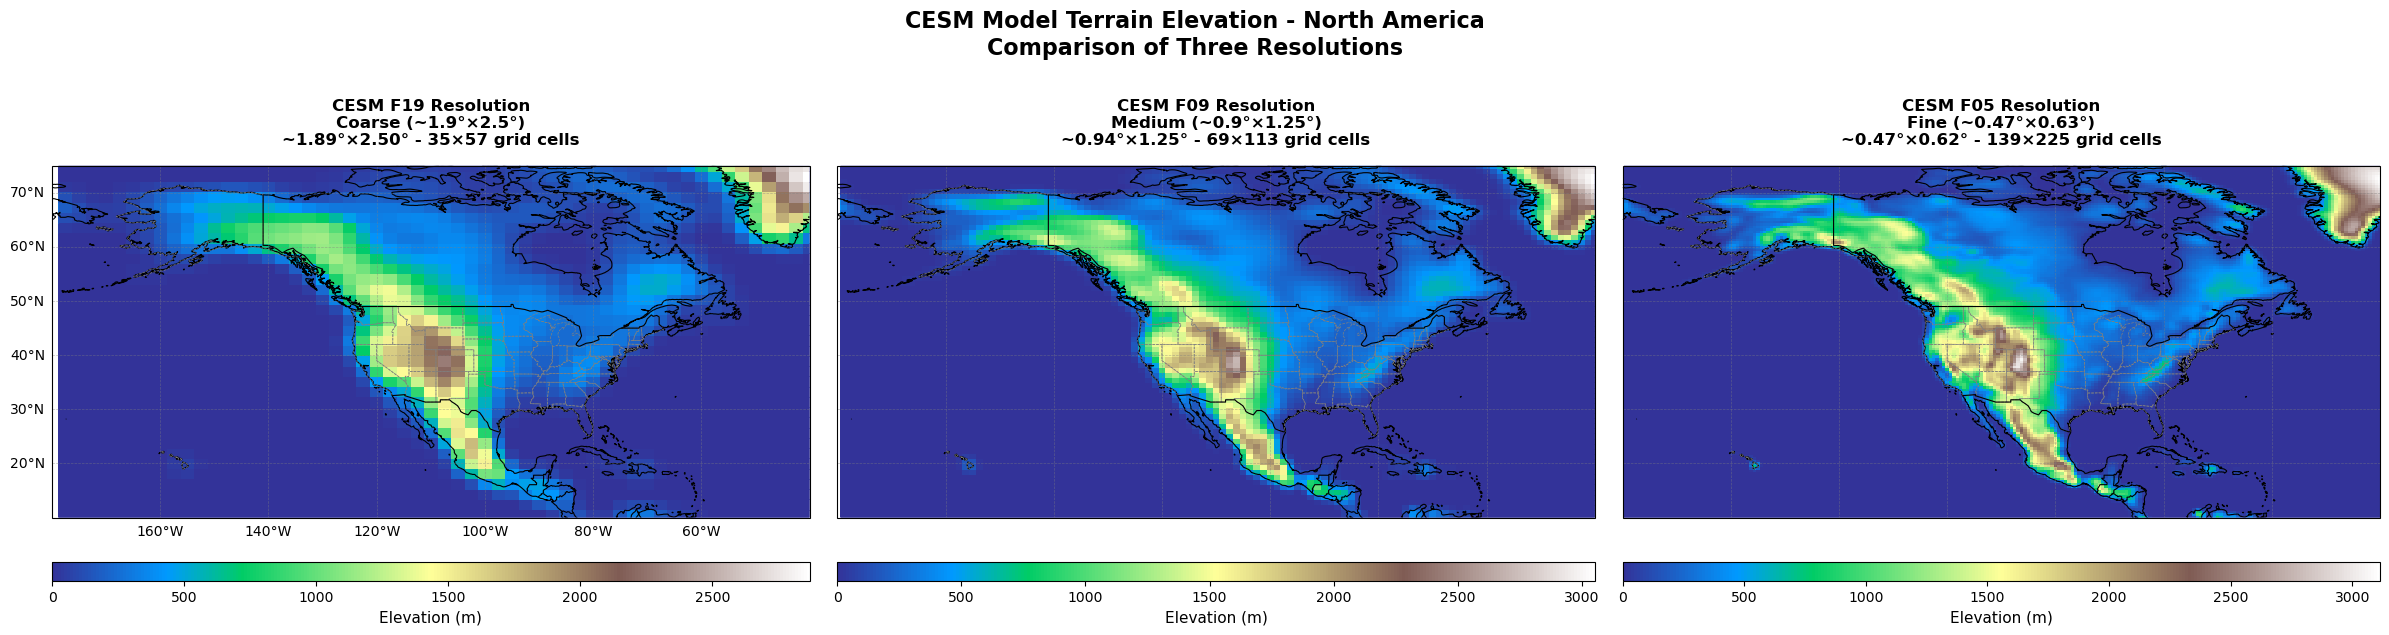

In [17]:
# Create comparison plot showing all three CESM resolutions side by side
fig, axes = plt.subplots(1, 3, figsize=(24, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Common settings
plot_extent = [-180, -40, 10, 75]
cmap = 'terrain'

# Plot each resolution using helper function
for idx, (resolution, data) in enumerate(cesm_datasets.items()):
    plot_cesm_terrain(
        axes[idx], 
        data['ds'], 
        data, 
        plot_extent, 
        cmap=cmap,
        show_labels=(idx == 0)  # Only show labels on leftmost plot
    )

# Add main title
plt.suptitle('CESM Model Terrain Elevation - North America\nComparison of Three Resolutions', 
             fontsize=16, fontweight='bold', y=0.7)

# Adjust layout to minimize whitespace
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
